In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import create_animation, imshow
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, diffx_tv, diffx_uq, diffy_vq, diffy_tu, filter_apply, filter_iteration, compute_isotropic_KE
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-dt', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-layers', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-filters', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-HPF', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-HPF-LPF', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/random-sampled', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-1D/momentum-4-1', additional_subfolder='output', prefix='momentum-4-1')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-1D/HPF', additional_subfolder='output', prefix='HPF')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-1D/HPF-LPF', additional_subfolder='output', prefix='HPF-LPF')

# Test of ZB offline model

In [36]:
import os 
import json
def compute_error(label):
    exp = ds[label]
    folder = exp.folder+'/..'
    with open(os.path.join(folder,'args.json')) as f:
        d = json.load(f)
    print(d)
    fx = exp.mom.ZB2020u
    fy = exp.mom.ZB2020v
    ffx, ffy = exp.ZB_offline(**d)
    fx = select_LatLon(fx)
    fy = select_LatLon(fy)
    ffx = select_LatLon(ffx)
    ffy = select_LatLon(ffy)
    error = Lk_error(ffx.isel(Time=-1),fx.isel(Time=-1)) + Lk_error(ffy.isel(Time=-1),fy.isel(Time=-1))
    return error

In [38]:
compute_error('EXP205-no-trace')

{'resolution': 'R4', 'DAYMAX': 7300.0, 'RESTINT': 1825.0, 'LAPLACIAN': 'False', 'BIHARMONIC': 'True', 'SMAGORINSKY_AH': True, 'SMAG_BI_CONST': 0.03, 'USE_ZB2020': 'True', 'amplitude': 7.0, 'ZB_type': 1, 'ZB_cons': 1, 'LPF_iter': 1, 'LPF_order': 4, 'HPF_iter': 2, 'HPF_order': 2, 'Stress_iter': 1, 'Stress_order': 2}


[0.000627009300613964,
 0.0013680203727900896,
 0.0006376177571907418,
 0.0014506996308712374]

In [4]:
compute_error('EXP205')

{'resolution': 'R4', 'DAYMAX': 7300.0, 'RESTINT': 1825.0, 'LAPLACIAN': 'False', 'BIHARMONIC': 'True', 'SMAGORINSKY_AH': True, 'SMAG_BI_CONST': 0.03, 'USE_ZB2020': 'True', 'amplitude': 7.0, 'ZB_type': 0, 'ZB_cons': 1, 'LPF_iter': 1, 'LPF_order': 4, 'HPF_iter': 2, 'HPF_order': 2, 'Stress_iter': 1, 'Stress_order': 2}


[0.0013508394999851906,
 0.0018097439182950593,
 0.00150977373433652,
 0.0015251861809581076]

In [31]:
(fx,fy) = ds['R16'].ZB_offline()

In [32]:
(fx_c,fy_c) = ds['R16'].ZB_offline_cartesian()

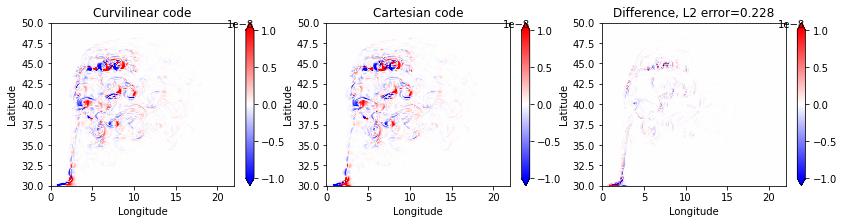

In [33]:
plt.figure(figsize=(14,3))
x = fx.isel(zl=0,Time=-1)
y = fx_c.isel(zl=0,Time=-1)
plt.subplot(1,3,1)
x.plot(vmin=-1e-8,vmax=1e-8,cmap='bwr')
plt.title('Curvilinear code')
plt.subplot(1,3,2)
y.plot(vmin=-1e-8,vmax=1e-8,cmap='bwr')
plt.title('Cartesian code')
plt.subplot(1,3,3)
(x-y).plot(vmin=-1e-8,vmax=1e-8,cmap='bwr')
plt.title(f'Difference, L2 error={round(Lk_error(select_LatLon(y),select_LatLon(x))[0],3)}')
plt.savefig('Cruvilinear-vs-Cartesian.png',dpi=300)

In [34]:
Lk_error(fx.isel(zl=0,Time=-1),fx_c.isel(zl=0,Time=-1))

[0.3484686198257359]

In [237]:
%%time
fx,fy = ds['R4'].ZB_offline()
fx.compute();
fy.compute();

CPU times: user 52 s, sys: 10.4 s, total: 1min 2s
Wall time: 48 s


<xarray.DataArray (yq: 81, xh: 88, zl: 2, Time: 243)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
...
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 21.12 21.38 21.62 21.88
  * yq       (yq) float64 30.0 30.25 30.5 30.75 31.0 ... 49.25 49.5 49.75 50.0
  * zl       (zl) float64 1.035e+03 1.036e+03
  * Time     (Time) float64 30.0 60.0 90.0 120.0 ... 7.23e+03 7.26e+03 7.29e+03

In [244]:
%%time
fx,fy = ds['R4'].ZB_offline(**{'resolution': 'R4', 'DAYMAX': 7300.0, 'RESTINT': 1825.0, 'LAPLACIAN': 'False', 'BIHARMONIC': 'True', 'SMAGORINSKY_AH': True, 'SMAG_BI_CONST': 0.03, 'USE_ZB2020': 'True', 'amplitude': 7.0, 'ZB_type': 0, 'ZB_cons': 1, 'LPF_iter': 1, 'LPF_order': 4, 'HPF_iter': 2, 'HPF_order': 2, 'Stress_iter': 1, 'Stress_order': 2})
fx.compute()
fy.compute()

CPU times: user 2min 47s, sys: 29.7 s, total: 3min 16s
Wall time: 2min 26s


<xarray.DataArray (yq: 81, xh: 88, zl: 2, Time: 243)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
...
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 21.12 21.38 21.62 21.88
  * yq       (yq) float64 30.0 30.25 30.5 30.75 31.0 ... 49.25 49.5 49.75 50.0
  * zl       (zl) float64 1.035e+03 1.036e+03
  * Time     (Time) float64 30.0 60.0 90.0 120.0 ... 7.23e+03 7.26e+03 7.29e+03

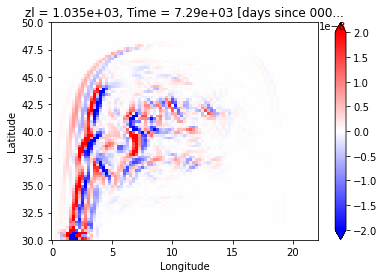

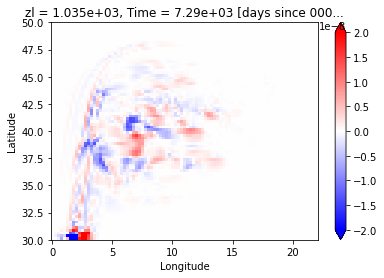

In [269]:
fx,fy = ds['R4'].ZB_offline(ZB_type=1)
fx.isel(Time=-1,zl=0).plot(vmin=-0.2e-7,vmax=0.2e-7,cmap='bwr')
plt.figure()
fx,fy = ds['R4'].ZB_offline()
fx.isel(Time=-1,zl=0).plot(vmin=-0.2e-7,vmax=0.2e-7,cmap='bwr')

In [66]:
fx0 = ds['Cs-0.1'].smagu
fy0 = ds['Cs-0.1'].smagv

In [70]:
fx, fy = ds['Cs-0.1'].Smagorinsky(Cs=0.1)

In [76]:
print(Lk_error(select_LatLon(fx0),select_LatLon(fx)))
print(Lk_error(select_LatLon(fy0),select_LatLon(fy)))

[0.09641426161927016, 0.1239796554530073]
[0.0959503337099039, 0.1604352959485676]


In [75]:
print(xr.corr(select_LatLon(fx0),select_LatLon(fx)).values)
print(xr.corr(select_LatLon(fy0),select_LatLon(fy)).values)

0.9966301674319359
0.9955988552035995


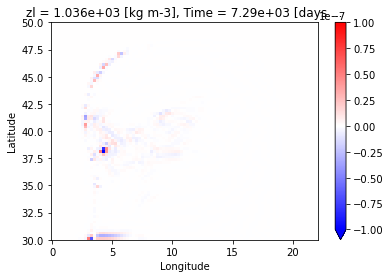

In [72]:
fx0.isel(zl=1,Time=-1).plot(vmin=-1e-7,vmax=1e-7,cmap='bwr')

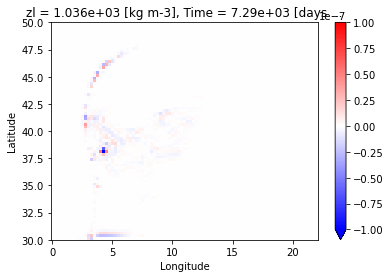

In [73]:
fx.isel(zl=1,Time=-1).plot(vmin=-1e-7,vmax=1e-7,cmap='bwr')

# Linearity in the amplitude

In [80]:
(fx,fy) = ds['R4'].ZB_offline(amplitude=1, **{'LPF_iter': 1, 'LPF_order': 4, 'HPF_iter': 2, 'HPF_order': 2, 'Stress_iter': 1, 'Stress_order': 2})
(fx10,fy10) = ds['R4'].ZB_offline(amplitude=10, **{'LPF_iter': 1, 'LPF_order': 4, 'HPF_iter': 2, 'HPF_order': 2, 'Stress_iter': 1, 'Stress_order': 2})

In [81]:
Lk_error(fx*10,fx10)

[4.999844998154921e-16, 1.3576587151969426e-08]

In [82]:
Lk_error(fy*10,fy10)

[4.2614059427286174e-16, 1.554689982962486e-08]